# 2025 CITS4012 Group 9 Assignment

<a href="https://colab.research.google.com/github/Kaichao-Zheng/CITS4012-NLP/blob/main/CITS4012_Group9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborators

| Uni ID   | Student Name  | GitHub Username                                   |
| -------- | ------------- | ------------------------------------------------- |
| 24141207 | Kaichao Zheng | [Kaichao-Zheng](https://github.com/Kaichao-Zheng) |
| 24645175 | Ziqi Meng     | [jiongge39](https://github.com/jiongge39)         |
| 23998001 | Yanglei Yuan  | [LeoYuan0225](https://github.com/LeoYuan0225)     |

# 0. Setup

> NOTE:
>
> In Google Colab, an ERROR would occur due to incompatibility of the latest versions of `numpy` and `scipy`.
>
> Simply **restart the runtime** to use the newly downgraded versions.

In [ ]:
%pip install word2number
%pip install contractions
%pip install nltk
%pip install pandas
%pip install gensim
%pip install matplotlib
%pip install wordcloud
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install scikit-learn

# 1. Overview

We implemented three different model architectures:

* [The Vanilla Bi-LSTM NLI Classifier](#scrollTo=67TQJgOJ_lF1)

* [Bi-LSTM + Attention NLI Classifier](#scrollTo=BhSE5ON4_r0C)

* [Model 3](#scrollTo=E4w_n2P2_xxm)

# 2. Data Preprocessing

## 2.1 Load JSON files from GitHub



In [ ]:
# Define JSON dataset paths
base_url = "https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/"

train_file = base_url + "train.json"
val_file = base_url + "validation.json"
test_file = base_url + "test.json"

# Quick check
print("✅ Dataset URLs:")
print("Train:\t", train_file)
print("Val:\t", val_file)
print("Test:\t", test_file)

In [ ]:
import pandas as pd

# Working dataframes
train_df = pd.read_json(train_file)
val_df = pd.read_json(val_file)
test_df = pd.read_json(test_file)

# Keep original copies
source_train_df = train_df.copy()
source_val_df = val_df.copy()
source_test_df = test_df.copy()

# Sneak peek
pd.set_option("display.max_colwidth", 30)

print(train_df.head())
# print(val_df.head())
# print(test_df.head())

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

pd.reset_option("display.max_colwidth")

## 2.2 Define difference viewer

In [ ]:
import html
from difflib import SequenceMatcher
from IPython.display import display, HTML

def verify_print(source_df, cleaned_df, tag, num, col, idx_src ,idx_now, kept=False):
  status = "Kept " if kept else "Reindexed"
  print(f"{tag} {num}:\tidx_src: {idx_src}\t{source_df[col][idx_src]}")
  print(f"{status} {num}:\tidx_now: {idx_now}\t{cleaned_df[col][idx_now]}")
  print()

# You can enable dark mode by replacing default "light" here
def verify_diff(source_df, cleaned_df, tag, num, col, index, kept=False, theme="dark"):
  if theme == "light":
    bg = "#fafafa"; fg = "#000000"
    del_bg = "#ffdddd"; ins_bg = "#ddffdd"
    del_fg = "#aa0000"; ins_fg = "#006600"
  else:
    bg = "#1e1e1e"; fg = "#e0e0e0"
    del_bg = "#662222"; ins_bg = "#224422"
    del_fg = "#ff9999"; ins_fg = "#99ff99"

  status = "Kept" if kept else "Fixed"

  original = source_df[col][index]
  cleaned = cleaned_df[col][index]

  matcher = SequenceMatcher(None, original, cleaned)

  html_original = f"""
  <div style='margin-bottom: 10px; background-color:{bg}; color:{fg}; white-space: nowrap; font-family: monospace; padding: 5px; border-radius:4px;'>
  <b>{tag} {num}:</b> """
  html_cleaned = f"""
  <div style='margin-bottom: 10px; background-color:{bg}; color:{fg}; white-space: nowrap; font-family: monospace; padding: 5px; border-radius:4px;'>
  <b>{status} {num}:</b> """

  for tag, i1, i2, j1, j2 in matcher.get_opcodes():
    orig_text = original[i1:i2].replace(" ", "&nbsp;")
    clean_text = cleaned[j1:j2].replace(" ", "&nbsp;")

    if tag == 'equal':
      html_original += orig_text
      html_cleaned += clean_text
    elif tag == 'delete':
      html_original += f"<span style='background-color:{del_bg}; color:{del_fg};'>{orig_text}</span>"
    elif tag == 'insert':
      html_cleaned += f"<span style='background-color:{ins_bg}; color:{ins_fg};'>{clean_text}</span>"
    elif tag == 'replace':
      html_original += f"<span style='background-color:{del_bg}; color:{del_fg};'>{orig_text}</span>"
      html_cleaned += f"<span style='background-color:{ins_bg}; color:{ins_fg};'>{clean_text}</span>"

  html_original += "</div>"
  html_cleaned += "</div>"

  display(HTML(html_original + html_cleaned + "<hr/>"))

## 2.3 Data cleansing

In principle, the data cleansing rules are derived solely from the training set to prevent information leakage.

This design intentionally preserves out-of-vocabulary (OOV) cases in the validation and test sets, which are represented by \<UNK> tag.

Assumption
* The value of `label` is binary, either "neutral" or "entails".

Compromises
* Ignore syntactic errors and semantic errors.
* Apply unified premises rules on hypothesis.

Handled Issues
| No. | Description | Examples |
|----------|-------------|-----------|
| Issue 1 | HTML/XML tags with ID pattern | train premise 78, 270, 319, ... |
| Issue 2 | Non-linguistic long/pure separators | train premise 1, 382, 385, ... |
| Issue 3 | Duplicate consecutive phrases | train premise 78, 87, 564, ... |
| Issue 4 | Single-word sentences  | train premise 146, 181, 427, ... |
| Issue 5 | Duplicated whitespaces | train premise 123, 193, 259, ... |
| Issue 6 | Spaces before punctuations, except '!' and '?' | train premise 3, 333, 6280 |
| Issue 7 | Premise with long concatenated sentences | train premise 270, 537, 608, ... |

Kept Noises

| No. | Description | Noise | Non-Noise |
|----------|-------------|----------|--------------|
| Noise 1 | Instructional prompt words | train premise 3, 61, 319, ... | train premise 16, 24, 61, ... |
| Noise 2 | Numbered markers | train premise 270, 537, 608, ... | train premise 1546, 2068, ... |
| Noise 3 | Misplaced `label` values | train premise 270, 537, 606, ... | train premise 1683, 2068, ... |
| Noise 4 | Metadata prefixes | train premise 32, 230, 482, ... |  |
| Noise 5 | Isolated single symbols | train premise 60, 1185 | comparison operators |


Limitation

The difference viewer automatically escapes HTML entities, which might overlook HTML noise. (E.g., &amp;quot; in train premise 420)

In [ ]:
import re

def cleanse(df):
  df = df.copy()

  ID_PATTERN = r"\b[A-Za-z]?(?:\d{6,}|[A-Za-z0-9]{8,})(?:-[A-Za-z0-9]{2,})+\b"
  REPEAT_PATTERN = r"\b((?:\w+\s+){0,2}\w+)( \1\b)+"

  for col in ["premise", "hypothesis"]:

    # pre-trim: two-tailed whitespaces
    df[col] = df[col].apply(lambda x: x.strip())

    # issue 1: HTML/XML tags with ID pattern
    df[col] = df[col].apply(html.unescape)
    df[col] = df[col].apply(lambda x: re.sub(r"<[^>]*>", " ", x))
    df[col] = df[col].apply(lambda x: re.sub(ID_PATTERN, " ", x))

    # issue 2: non-linguistic long/pure separators
    df[col] = df[col].apply(lambda x: re.sub(r"[-=*_~$]{3,}", " ", x))
    df[col] = df[col].apply(lambda x: "" if re.fullmatch(r"[\W_]+", x.strip()) else x)

    # issue 3: duplicate consecutive phrases
    df[col] = df[col].apply(lambda x: re.sub(REPEAT_PATTERN, r"\1", x))

    # issue 4: single-word sentences
    df[col] = df[col].apply(lambda x: "" if re.fullmatch(r"(\w+[.!?']?|[^\w\s]+)", x.strip()) else x)

    # issue 5: duplicate whitespaces
    df[col] = df[col].apply(lambda x: re.sub(r"\s+", " ", x).strip())

    # issue 6: spaces before punctuations
    df[col] = df[col].apply(lambda x: re.sub(r"\s+([.,;:])", r"\1", x))

  return df

# Clenasing
train_df = cleanse(train_df)
val_df = cleanse(val_df)
test_df = cleanse(test_df)

# Keep cleaned copies
cleaned_train_df = train_df.copy()
cleaned_val_df = val_df.copy()
cleaned_test_df = test_df.copy()

# Verification
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=1, col="premise", index=319)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=2, col="premise", index=1)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=3, col="premise", index=87)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=4, col="premise", index=146)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=5, col="premise", index=123)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=3)
# verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=6280, kept=True)  # why except '?'
# verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=333, kept=True)  # why except '!'
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num="Hybrid", col="premise", index=270)

## 2.4 Normalization

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sww = stopwords.words('english')

In [ ]:
import re, contractions
from nltk.tokenize import word_tokenize, sent_tokenize
from word2number import w2n
from contractions import fix as expand_contractions

def word2num(text):
  def convert(match):
    word = match.group(0)
    try:
      return f" {w2n.word_to_num(word)} "
    except:
      return f" {word} "
  text = re.sub(
    r'\b(?:zero|one|two|three|four|five|six|seven|eight|nine|ten|'
    r'eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|'
    r'eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|'
    r'eighty|ninety|hundred|thousand|million|billion|and|[- ])+\b',
    convert, text)
  return ' '.join(text.split())

def normalize(df):
  df = df.copy()

  for col in ["premise", "hypothesis"]:

    # rule 1: lowercase
    df[col] = df[col].str.lower()

    # rule 2: expand contraction
    df[col] = df[col].apply(expand_contractions)

    # rule -1: remove stopwords
    # df[col] = df[col].apply(lambda x: " ".join([w for w in word_tokenize(x) if w.lower() not in sww]))

    # rule -2: remove bracketed content
    # df[col] = df[col].apply(lambda x: re.sub(r'\([^)]*\)', '', x))

    # rule -3: symbolize linguistic numbers
    # df[col] = df[col].apply(word2num)

  return df

# Normalization
train_df = normalize(train_df)
val_df = normalize(val_df)
test_df = normalize(test_df)

# Keep normalized copies
normalized_train_df = train_df.copy()
normalized_val_df = val_df.copy()
normalized_test_df = test_df.copy()

# Verification
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="1", col="premise", index=1)
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="2", col="premise", index=420)
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="2", col="hypothesis", index=8, kept=True)

# Inactivate rules
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-1, col="premise", index=1, kept=True)
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-2, col="premise", index=8, kept=True)
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-3, col="premise", index=147, kept=True)

## 2.5 Reindexing

In [ ]:
def reindex(df):
  df = df.copy()

  for col in ["premise", "hypothesis"]:

    # post-issue 4: remove rows with empty cell
    df = df[df[col].astype(str).str.strip() != ""]

  # issue 7: premise with long concatenated sentences
  new_rows = []
  for _, row in df.iterrows():
    premise = str(row["premise"]).strip()
    hypothesis = str(row["hypothesis"]).strip()
    label = str(row["label"]).strip()

    if not premise:
      continue

    # split by ". " or "; " to avoid 3.14
    sentences = re.split(r'(?<!\d)(?<=[.;])\s+(?=[A-Za-z])', premise)
    sentences = [s.strip() for s in sentences if s.strip()]

    for s in sentences:
      new_rows.append({
        "premise": s,
        "hypothesis": hypothesis,
        "label": label
      })
  df = pd.DataFrame(new_rows)

  # reorder index
  df = df.reset_index(drop=True)

  return df

# Reindexing
train_df = reindex(train_df)
val_df = reindex(val_df)
test_df = reindex(test_df)

# Keep reindexed copies
reindexed_train_df = train_df.copy()
reindexed_val_df = val_df.copy()
reindexed_test_df = test_df.copy()

# Verification
verify_print(normalized_train_df, reindexed_train_df, tag="Post-Issue", num=4, col="premise", idx_src=147, idx_now=158)
verify_print(normalized_train_df, reindexed_train_df, tag="Issue", num=7, col="premise", idx_src=31, idx_now=31, kept=True)
verify_print(normalized_train_df, reindexed_train_df, tag="Issue", num=7, col="premise", idx_src=270, idx_now=281)

## 2.6 Tokenization

In [ ]:
import nltk
nltk.download('punkt_tab')

In [ ]:
import string

def protect_float(text: str) -> str:
  return re.sub(r"(?<=\d)\.(?=\d)", "DOTTK", text)

def recover_float(tokens):
  return [t.replace("DOTTK", ".") for t in tokens]

def tokenize(df):
  df = df.copy()
  KEEP_SYMBOLS = set("=<>+-/*%!")

  for col in ["premise", "hypothesis"]:
    # Remove punctuations
    df[col] = df[col].apply(lambda x: protect_float(x))
    df[col] = df[col].apply(lambda x: [t for t in word_tokenize(x) if t not in string.punctuation or t in KEEP_SYMBOLS])
    df[col] = df[col].apply(lambda toks: recover_float(toks))

  return df

# Tokenization
tokenized_train_df = tokenize(train_df)
tokenized_val_df = tokenize(val_df)
tokenized_test_df = tokenize(test_df)

# Quick check
preview_rows = pd.concat([
  tokenized_train_df.head(),
  tokenized_train_df.iloc[[6, 23, 34, 62, 369, 438, 2116]]  # concatenate indeces 6, 23, 32, 60, 319, 385, 1185
])

display(preview_rows)

## 2.7 Visualisation via Word Cloud

We actually include stopwords in the tokenized dataframes for model training,

but temporarily remove them here for visualisation purposes.

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
sww = stopwords.words('english')

for col in ["premise", "hypothesis"]:
  tokens = []
  # Remove punctuation, number, and stopword tokens temporarily
  for toks in tokenized_train_df[col]:
    tokens.extend([t.lower() for t in toks if t.isalpha() and t.lower() not in sww])
  wordcloud = WordCloud(background_color="white").generate(" ".join(tokens))
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"{col.capitalize()} Word Cloud (Train Set)")
  plt.show()

# 3. Word Embedding

## 3.1 Token vocabulary

The vocabulary only includes tokens in train set with `frequency >= 3`.

Therefore, a token with low frequency will be regarded as \<UNK>.

E.g. the token "6.39" from the first premise.

In [ ]:
from collections import Counter

def build_vocab(df, min_freq=3):
  counter = Counter()
  for col in ["premise", "hypothesis"]:
    for toks in df[col]:
      counter.update(toks)

  # special tokens
  vocab = {"<PAD>": 0,"<UNK>": 1}
  for token, freq in counter.items():
    if freq >= min_freq and token not in vocab:
      vocab[token] = len(vocab)

  return vocab

vocab = build_vocab(tokenized_train_df)
print("Vocab size:\t", {len(vocab)})
print("Sample vocab:\t", list(vocab.keys())[:20])

## 3.3 One-hot key embedding

Map each token to its one-hot key from the vocabulary.

In [ ]:
def word_to_index(df, vocab):
  df = df.copy()

  for col in ["premise", "hypothesis"]:
    df[col] = df[col].apply(lambda toks: [vocab.get(w, vocab["<UNK>"]) for w in toks])

  label_map = {"neutral": 0, "entails": 1}
  if "label" in df.columns:
    df["label"] = df["label"].map(label_map).fillna(-1).astype(int)

  return df

# One-hot key embedding
indexed_train_df = word_to_index(tokenized_train_df, vocab)
indexed_val_df = word_to_index(tokenized_val_df, vocab)
indexed_test_df = word_to_index(tokenized_test_df, vocab)

display(indexed_train_df.head())

# 4. Model Implementation

## 4.1 Training Configuration

### 4.1.1 Enable cuda GPU acceleration

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4.1.2 Shared hyperparameters


In [ ]:
from types import SimpleNamespace

shared = SimpleNamespace(
  vocab_size = len(vocab),
  embed_dim = 256,
  hidden_dim = 256,
  num_layers = 1,
  dropout = 0.1,
  num_classes = 2,      # len(label_mapping)
  label_mapping = {"neutral": 0, "entails": 1},
  batch_size = 128,
  learning_rate = 1e-3,
  total_epoch = 20,
  pad_idx = vocab["<PAD>"],
  unk_idx = vocab["<UNK>"],
)

### 4.1.3 Padding

In [ ]:
def pad(seq, max_len):
  return seq + [shared.pad_idx] * (max_len - len(seq))

def pad_seq(df):
  df = df.copy()

  max_prem = max(df["premise"].apply(len))
  max_hypo = max(df["hypothesis"].apply(len))

  df["premise"] = df["premise"].apply(lambda s: pad(s, max_prem))
  df["hypothesis"] = df["hypothesis"].apply(lambda s: pad(s, max_hypo))

  return df

# Padding
pad_train_df = pad_seq(indexed_train_df)
pad_val_df = pad_seq(indexed_val_df)
pad_test_df = pad_seq(indexed_test_df)

# Verification
pd.set_option("display.max_colwidth", 60)
display(pad_train_df.head())
pd.reset_option("display.max_colwidth")

### 4.1.4 Batching

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def make_batch(pad_df):
  batch_size = shared.batch_size

  premises_tensor = torch.tensor(pad_df["premise"].tolist())
  hypotheses_tensor = torch.tensor(pad_df["hypothesis"].tolist())
  labels_tensor = torch.tensor(pad_df["label"].tolist())

  dataset = TensorDataset(premises_tensor, hypotheses_tensor, labels_tensor)
  loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  return loader

train_loader = make_batch(pad_train_df)
val_loader = make_batch(pad_val_df)
test_loader = make_batch(pad_test_df)

## 4.2 Model 1: The Vanilla NLI Classifier

This baseline model is inspired by the classic SNLI model proposed by [Bowman et al.](https://arxiv.org/abs/1508.05326)
* Single Bi-LSTM recurrent layer
* Dropout applied to encoders and classifier
* The value of `label` is either "neutral" or "entails"
* Validation set used for monitoring overfitting
* Remains affected by the OOV limitation
* No attention mechanism

Its ablation counterpart is inspired by the SA-NLI model proposed by [Li et al.](https://www.sciencedirect.com/science/article/pii/S0925231220304793#sec0017), which introduces **dual-attention mechanism** before concatenation.
* Inherit from the vanilla model to keep the ablation setup consistent
* Overrides the `forward()` method to change model architecture
* Combines both self-attention (within each sentence) and cross-attention (between premise and hypothesis)

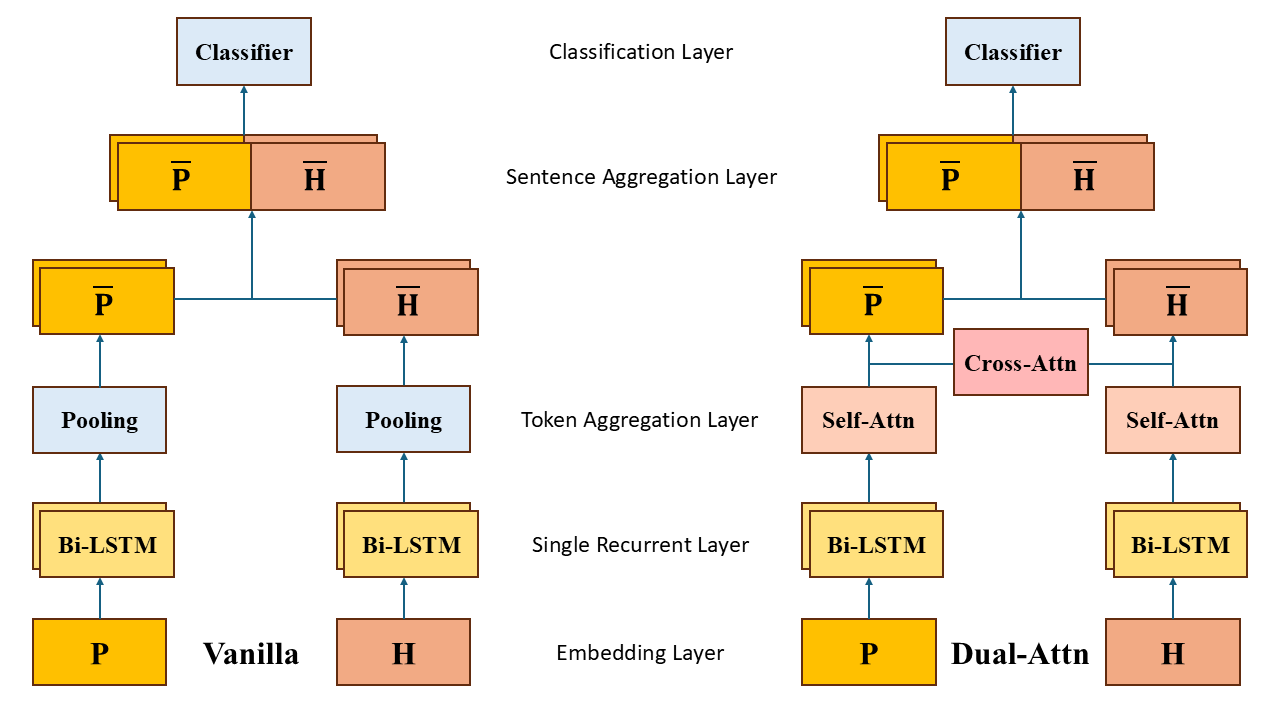

### 4.2.1 Ablation models

#### The vanilla NLI model without attention

In [ ]:
import torch.nn as nn

class Vanilla_NLI_Model(nn.Module):
  def __init__(self, shared):
    super().__init__()

    # Embedding layer
    self.prem_embedding = nn.Embedding(shared.vocab_size, shared.embed_dim, padding_idx=shared.pad_idx) # discard <PAD>
    self.hypo_embedding = nn.Embedding(shared.vocab_size, shared.embed_dim, padding_idx=shared.pad_idx) # discard <PAD>

    # Encoding Layer
    self.encoder = nn.LSTM(
      input_size=shared.embed_dim,
      hidden_size=shared.hidden_dim,
      num_layers=shared.num_layers,                  # single recurrent layer
      dropout=shared.dropout if shared.num_layers > 1 else 0.0, # disabled， dropout only applies between recurrent layers
      bidirectional=True,                       # Bi-LSTM
      batch_first=True                        # (B, T, E)
    )

    # Regularization to prevent overfitting
    self.dropout_encoder = nn.Dropout(shared.dropout)

    # Classification layer
    feat_dim = 2 * (2 * shared.hidden_dim)            # (prem + hypo) × BiLSTM(2H each) = 4H
    self.classifier = nn.Linear(feat_dim, shared.num_classes)    # simplest linear classifier

  def forward(self, prem_ids, hypo_ids):
    # Encode premise
    prem_embed = self.prem_embedding(prem_ids)            # (B, T_p, E)
    _, (prem_h, _) = self.encoder(prem_embed)           # return encoder_output, (prem_hidden_state, prem_cell_state)
    # Token Aggregation: concat two-direction final hidden states
    prem_vec = torch.cat([prem_h[-2], prem_h[-1]], dim=1)     # (B, 2H)
    prem_vec = self.dropout_encoder(prem_vec)            # apply dropout to concatenated premise hidden state

    # Encode hypothesis
    hypo_embed = self.hypo_embedding(hypo_ids)            # (B, T_h, E)
    _, (hypo_h, _) = self.encoder(hypo_embed)           # return encoder_output, (hypo_hidden_state, hypo_cell_state)
    # Token Aggregation: concat two-direction final hidden states
    hypo_vec = torch.cat([hypo_h[-2], hypo_h[-1]], dim=1)     # (B, 2H)
    hypo_vec = self.dropout_encoder(hypo_vec)            # apply dropout to concatenated hypothesis hidden state

    # Sentence Aggregation: combine premise and hypothesis as unified input for classifier
    combined = torch.cat([prem_vec, hypo_vec], dim=1)       # (B, 4H)
    combined = self.dropout_encoder(combined)            # apply dropout to combined premise-hypothesis representation

    # Classification
    logits = self.classifier(combined)                # (B, shared.num_classes)

    return logits

#### The vanilla NLI model with dual-attention

In [ ]:
import torch.nn as nn

class DualAttn_NLI_Model(Vanilla_NLI_Model):                # inherit vanilla NLI
  def __init__(self, shared):
    super().__init__(shared)

    self.self_attn = nn.Linear(2 * shared.hidden_dim, 1, bias=False)
    self.cross_attn = nn.Linear(2 * shared.hidden_dim, 2 * shared.hidden_dim, bias=False)

  def apply_self_attention(self, encoder_outputs):
    attn_scores = self.self_attn(encoder_outputs)            # (B, T, 1)
    attn_weights = torch.softmax(attn_scores, dim=1)          # (B, T, 1)
    attended_vec = torch.sum(attn_weights * encoder_outputs, dim=1) # (B, 2H)
    return attended_vec

  def apply_cross_attention(self, src_vec, tar_vec):
    attn_scores = torch.bmm(src_vec.unsqueeze(1), tar_vec.unsqueeze(2)) # (B, 1, 1)
    attn_weights = torch.sigmoid(attn_scores)              # (B, 1, 1)
    context = attn_weights.squeeze(2) * tar_vec            # (B, 2H)
    return src_vec + context                      # (B, 2H) residual fusion

  def forward(self, prem_ids, hypo_ids):
    # Encode premise
    prem_embed = self.prem_embedding(prem_ids)            # (B, T_p, E)
    prem_out, _ = self.encoder(prem_embed)             # return encoder_output, (prem_hidden_state, prem_cell_state)
    # Self-attention layer
    prem_self = self.apply_self_attention(prem_out)         # (B, 2H)
    prem_self = self.dropout_encoder(prem_self)           # apply dropout to attended premise hidden state

    # Encode hypothesis
    hypo_embed = self.hypo_embedding(hypo_ids)            # (B, T_h, E)
    hypo_out, _ = self.encoder(hypo_embed)             # return encoder_output, (hypo_hidden_state, hypo_cell_state)
    # Self-attention layer
    hypo_self = self.apply_self_attention(hypo_out)         # (B, 2H)
    hypo_self = self.dropout_encoder(hypo_self)           # apply dropout to attended hypothesis hidden state

    # Cross-attention layer
    prem_cross = self.apply_cross_attention(prem_self, hypo_self)  # (B, 2H)
    hypo_cross = self.apply_cross_attention(hypo_self, prem_self)  # (B, 2H)

    # Sentence Aggregation: combine premise and hypothesis as unified input for classifier
    combined = torch.cat([prem_self, hypo_self], dim=1)       # (B, 4H)
    combined = self.dropout_encoder(combined)            # apply dropout to combined premise-hypothesis representation

    # Classification
    logits = self.classifier(combined)                # (B, shared.num_classes)

    return logits

### 4.2.2 Training (3+4 min)

In [ ]:
import torch.optim as optim

m1_vanilla_model = Vanilla_NLI_Model(shared).to(device)
m1_dual_attn_model = DualAttn_NLI_Model(shared).to(device)

criterion = nn.CrossEntropyLoss()      # combine LogSoftmax and NLLLoss

vanilla_optimizer = optim.Adam(m1_vanilla_model.parameters(), lr=shared.learning_rate)
dual_attn_optimizer = optim.Adam(m1_dual_attn_model.parameters(), lr=shared.learning_rate)

In [ ]:
m1_vanilla_train_losses = []
m1_vanilla_val_losses = []

for epoch in range(shared.total_epoch):
  m1_vanilla_model.train()
  train_loss = 0

  # Training loop
  for prem, hypo, label in train_loader:
    prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

    # Forward
    logits = m1_vanilla_model(prem, hypo)
    loss = criterion(logits, label)

    # Backward and optimize
    vanilla_optimizer.zero_grad()
    loss.backward()
    vanilla_optimizer.step()

    # Accumulate batch loss
    train_loss += loss.item()

  train_avg_loss = train_loss / len(train_loader)
  m1_vanilla_train_losses.append(train_avg_loss)

  # Validation
  m1_vanilla_model.eval()
  m2_val_loss = 0
  with torch.no_grad():
    for prem, hypo, label in val_loader:
      prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

      # Forward
      logits = m1_vanilla_model(prem, hypo)
      loss = criterion(logits, label)

      # Accumulate batch loss
      m2_val_loss += loss.item()

  val_avg_loss = m2_val_loss / len(val_loader)
  m1_vanilla_val_losses.append(val_avg_loss)

  print(f"Vanilla Epoch: {epoch+1}/{shared.total_epoch}\tTrain Loss: {train_avg_loss:.4f}\tVal Loss: {val_avg_loss:.4f}")

In [ ]:
m1_dual_attn_train_losses = []
m1_dual_attn_val_losses = []

for epoch in range(shared.total_epoch):
  m1_dual_attn_model.train()
  train_loss = 0

  # Training loop
  for prem, hypo, label in train_loader:
    prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

    # Forward
    logits = m1_dual_attn_model(prem, hypo)
    loss = criterion(logits, label)

    # Backward and optimize
    dual_attn_optimizer.zero_grad()
    loss.backward()
    dual_attn_optimizer.step()

    # Accumulate batch loss
    train_loss += loss.item()

  train_avg_loss = train_loss / len(train_loader)
  m1_dual_attn_train_losses.append(train_avg_loss)

  # Validation
  m1_dual_attn_model.eval()
  m2_val_loss = 0
  with torch.no_grad():
    for prem, hypo, label in val_loader:
      prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

      # Forward
      logits = m1_dual_attn_model(prem, hypo)
      loss = criterion(logits, label)

      # Accumulate batch loss
      m2_val_loss += loss.item()

  val_avg_loss = m2_val_loss / len(val_loader)
  m1_dual_attn_val_losses.append(val_avg_loss)

  print(f"Dual-Attn Epoch: {epoch+1}/{shared.total_epoch}\tTrain Loss: {train_avg_loss:.4f}\tVal Loss: {val_avg_loss:.4f}")

### 4.2.3 Loss curves

In [ ]:
import matplotlib.pyplot as plt

epoch = range(1, shared.total_epoch + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Training Loss
axes[0].plot(epoch, m1_vanilla_train_losses, color='blue', label='No Attn')
axes[0].plot(epoch, m1_dual_attn_train_losses, color='orange', label='Dual-Attn')
axes[0].set_title('Training Loss per Epoch')
axes[0].set_xticks(epoch)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Average Loss')
axes[0].grid(axis='y')
axes[0].legend()

# Validation Loss
axes[1].plot(epoch, m1_vanilla_val_losses, color='blue', label='No Attn')
axes[1].plot(epoch, m1_dual_attn_val_losses, color='orange', label='Dual-Attn')
axes[1].set_title('Validation Loss per Epoch')
axes[1].set_xticks(epoch)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Average Loss')
axes[1].grid(axis='y')
axes[1].legend()

plt.show()

### 4.2.4 Testing

In [ ]:
from sklearn.metrics import accuracy_score

# Testing

def evaluate_accuracy(model, test_loader, device, name):
  model.eval()
  preds, labels = [], []
  with torch.no_grad():
    for prem, hypo, label in test_loader:
      prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)
      logits = model(prem, hypo)
      pred = torch.argmax(logits, dim=1)
      preds.extend(pred.cpu().numpy())
      labels.extend(label.cpu().numpy())
  acc = accuracy_score(labels, preds)
  print(f"{name} Test Accuracy: {acc:.4f}")
  return acc, preds, labels

m1_vanilla_acc, m1_vanilla_preds, m1_vanilla_labels = evaluate_accuracy(m1_vanilla_model, test_loader, device, name="Vanilla")
m1_dual_attn_acc, m1_dual_attn_preds, m1_dual_attn_labels = evaluate_accuracy(m1_dual_attn_model, test_loader, device, name="Dual-Attn")

### 4.2.5 Classification Matrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Classification matrices
print("================== Vanilla BiLSTM NLI ==================")
print(classification_report(m1_vanilla_labels, m1_vanilla_preds, target_names=list(shared.label_mapping.keys())))

print("\n================= Dual-Attn BiLSTM NLI =================")
print(classification_report(m1_dual_attn_labels, m1_dual_attn_preds, target_names=list(shared.label_mapping.keys())))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

cm_vanilla = confusion_matrix(m1_vanilla_labels, m1_vanilla_preds)
disp_vanilla = ConfusionMatrixDisplay(confusion_matrix=cm_vanilla, display_labels=list(shared.label_mapping.keys()))
disp_vanilla.plot(cmap="Blues", ax=axes[0], colorbar=False)
axes[0].set_title("Vanilla Confusion Matrix")

cm_dual = confusion_matrix(m1_dual_attn_labels, m1_dual_attn_preds)
disp_dual = ConfusionMatrixDisplay(confusion_matrix=cm_dual, display_labels=list(shared.label_mapping.keys()))
disp_dual.plot(cmap="Blues", ax=axes[1], colorbar=False)
axes[1].set_title("Dual-Attn Confusion Matrix")

plt.tight_layout()
plt.show()

### 4.2.6 Evaluation

In summary, the model struggles to predict OOV words, regardless of how much content it has learned from the training set.

#### Training Loss

The training loss of both models shows a similar trends that decreases rapidly and stabilizes around epoch 10, indicating that the model successfully fits the training data.

The train loss of the model with dual-attention often more stable than the one without attention.

The consistent convergence pattern suggests that thiese vanilla NLI classicier models are capable of capturing the sequence patterns within the training distribution.

#### Validation Loss

The validation loss rises steadily throughout training, revealing a clear sign of overfitting.

This outcome is expected. Since the word-to-index vocabulary was intentionally built only from the training set

As a result, unseen or rare tokens are replaced by the \<UNK> tag, leading to higher loss and reduced generalization capability.

#### Classification Matrics

The dual-attention mechanism does not notably improve overall accuracy, but enhances the prediction of the **true positive** label "entails". This is likely due to label imbalance in training set:

Two-thirds of the training data are "neutral", while the validation and test sets are balanced. This make the vanilla model to underperform on "entails" examples.

## 4.3 Model 2: Bi-LSTM + Attention NLI Classifier

### 4.3.1 Model

In [ ]:
# ============================================================
# NLI BiLSTM with Attention (Classifier + Training Loop)
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

class NLI_BiLSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 8, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def attention_pool(self, lstm_out):
        attn_weights = F.softmax(self.attn(lstm_out), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(attn_weights * lstm_out, dim=1)   # [batch, hidden_dim*2]
        return context

    def forward(self, premise, hypothesis):
        # Encode premise
        prem_embed = self.embedding(premise)
        prem_out, _ = self.bilstm(prem_embed)
        prem_vec = self.attention_pool(prem_out)

        # Encode hypothesis
        hyp_embed = self.embedding(hypothesis)
        hyp_out, _ = self.bilstm(hyp_embed)
        hyp_vec = self.attention_pool(hyp_out)

        # Combine
        combined = torch.cat([
            prem_vec,
            hyp_vec,
            torch.abs(prem_vec - hyp_vec),
            prem_vec * hyp_vec
        ], dim=1)

        logits = self.fc(combined)
        return logits

### 4.3.2 Training (4 min)

In [ ]:
# Assuming label_mapping and shared are already defined
# Define the number of classes from the label_mapping

model_2 = NLI_BiLSTM_Attention(
    vocab_size=len(vocab),
    embed_dim=shared.embed_dim,
    hidden_dim=shared.hidden_dim,
    num_classes=shared.num_classes,
    pad_idx=shared.pad_idx
).to(device)

m2_criterion = nn.CrossEntropyLoss()
m2_optimizer = torch.optim.Adam(model_2.parameters(), lr=shared.learning_rate)

m2_train_losses, m2_val_losses = [], []

for epoch in range(shared.total_epoch):
    # ---------- TRAIN ----------
    model_2.train()
    running_loss, preds, labels_all = 0, [], []
    for premise, hypothesis_in, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{shared.total_epoch}"):
        premise, hypothesis_in, labels = premise.to(device), hypothesis_in.to(device), labels.to(device)
        m2_optimizer.zero_grad()
        outputs = model_2(premise, hypothesis_in)
        loss = m2_criterion(outputs, labels)
        loss.backward()
        m2_optimizer.step()

        running_loss += loss.item()
        preds.extend(outputs.argmax(1).cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

    train_acc = accuracy_score(labels_all, preds)
    train_loss = running_loss / len(train_loader)
    m2_train_losses.append(train_loss)

    # ---------- VALIDATION ----------
    model_2.eval()
    m2_val_loss, m2_val_preds, m2_val_labels = 0, [], []
    with torch.no_grad():
        for premise, hypothesis_in, labels in val_loader:
            premise, hypothesis_in, labels = premise.to(device), hypothesis_in.to(device), labels.to(device)
            outputs = model_2(premise, hypothesis_in)
            loss = m2_criterion(outputs, labels)
            m2_val_loss += loss.item()
            m2_val_preds.extend(outputs.argmax(1).cpu().numpy())
            m2_val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(m2_val_labels, m2_val_preds)
    m2_val_loss /= len(val_loader)
    m2_val_losses.append(m2_val_loss)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={m2_val_loss:.4f}, Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

### 4.3.3 Evaluation

In [ ]:
# Final evaluation metrics
print("Classification Report:")
print(classification_report(m2_val_labels, m2_val_preds, target_names=list(shared.label_mapping.keys())))

# Confusion Matrix
cm = confusion_matrix(m2_val_labels, m2_val_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(shared.label_mapping.keys())).plot(cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()

# Plot Loss Curves
plt.figure(figsize=(6,4))
plt.plot(m2_train_losses, label="Train Loss", marker='o')
plt.plot(m2_val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()

## 4.4 Model 3